In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%run Common.ipynb

In [3]:
import pandas as pd
import pytz
utc_tz = pytz.UTC
pst_tz = pytz.timezone('America/Los_Angeles')

In [4]:
import glob
basedir = 'data/ECE219_tweet_data/'

datafilenames = [i for i in glob.iglob(basedir + '*.txt')]
datafilenames

['data/ECE219_tweet_data/tweets_#gopatriots.txt',
 'data/ECE219_tweet_data/tweets_#nfl.txt',
 'data/ECE219_tweet_data/tweets_#patriots.txt',
 'data/ECE219_tweet_data/tweets_#superbowl.txt',
 'data/ECE219_tweet_data/tweets_#sb49.txt',
 'data/ECE219_tweet_data/tweets_#gohawks.txt']

In [5]:
hashtags = [f.split('#')[1].replace('.txt','') for f in datafilenames]
hashtags

['gopatriots', 'nfl', 'patriots', 'superbowl', 'sb49', 'gohawks']

In [6]:
# load the extracted features
df_features = {}

for hashtag in log_progress(hashtags):
    tweet_features = pickle_load(basedir + 'tweets_#' + hashtag +'.txt.pkl.gz')
    df_features[hashtag] = pd.DataFrame(tweet_features)

VBox(children=(HTML(value=''), IntProgress(value=0, max=6)))

In [7]:
agg_params = {
    'time': 'count', # num_tweets
    're_count': 'sum', # num_retweets
    'fo_count': ['sum', 'max'], # num_followers, max_followers
    'media_count': 'sum', # num_media
    'tweet_len': 'mean' # avg_tweet_len
}

rename_params = {
    'citetime_pst_': 'window',
    'time_count': 'num_tweets',
    're_count_sum': 'num_retweets',
    'fo_count_sum': 'num_followers',
    'fo_count_max': 'max_followers',
    'media_count_sum': 'num_media',
    'tweet_len_mean': 'avg_tweet_len'
}


def create_windowed_data(df_hashtag, freq):
    df_windowed = df_hashtag.groupby(pd.Grouper(key='citetime_pst', freq=freq)).agg(agg_params)
    df_windowed.fillna(0, inplace=True)
    df_windowed.reset_index(inplace=True)
    df_windowed.sort_values(by='citetime_pst', inplace=True)
    df_windowed.columns = ["_".join(x) for x in df_windowed.columns.ravel()]
    df_windowed.rename(columns=rename_params, inplace=True)
    # add hour-of-day column
    df_windowed['hour_of_day'] = [i.hour for i in df_windowed.window]
    # add num tweets for next time window column by shifting the num_tweets column up
    df_windowed['num_tweets_next_window'] = np.array(df_windowed.num_tweets.shift(-1).fillna(0)).astype(int)
    # add previous window num_tweets delta
    df_windowed['num_tweets_delta'] = df_windowed.num_tweets - df_windowed.num_tweets.shift(1).fillna(0)
    return df_windowed

df_windowed = {}
for hashtag in df_features.keys():
    # group into 1-hour windows and aggregate data
    df_windowed[hashtag] = create_windowed_data(df_features[hashtag], '60min')

In [8]:
df_windowed['nfl'].head()

window  num_tweets  num_media  num_retweets  \
0 2015-01-14 00:00:00-08:00          55          4            62   
1 2015-01-14 01:00:00-08:00          51          7            56   
2 2015-01-14 02:00:00-08:00          54          5            94   
3 2015-01-14 03:00:00-08:00          60          9           125   
4 2015-01-14 04:00:00-08:00          57          4           184   

   num_followers  max_followers  avg_tweet_len  hour_of_day  \
0        96256.0        10658.0     120.581818            0   
1        87168.0        12225.0     118.000000            1   
2       100225.0        10658.0     118.388889            2   
3        85903.0        12225.0     121.200000            3   
4       113695.0        14979.0     119.140351            4   

   num_tweets_next_window  num_tweets_delta  
0                      51              55.0  
1                      54              -4.0  
2                      60               3.0  
3                      57               6.0  
4                      73              -3.0

In [9]:
%%script false

import statsmodels.api as sm
from patsy import dmatrices
from sklearn.metrics import mean_squared_error, r2_score

formula = 'num_tweets_next_window ~ hour_of_day + num_tweets + num_retweets + num_followers + max_followers + avg_tweet_len + num_media + num_tweets_delta - 1'

df_res = {}

for hashtag in df_windowed.keys():
    df_windowed_feature = df_windowed[hashtag]
    print("%s:" %hashtag)
    y, X = dmatrices(formula, data=df_windowed_feature, return_type='dataframe')
    mod = sm.OLS(y, X)    # Describe model
    res = mod.fit()       # Fit model
    df_res[hashtag] = res
    print("\tMSE:\t\t%f" %res.mse_resid)
    print("\tR^2:\t\t%f" %res.rsquared)
    y_pred = res.predict(X)
    print("\tsklearn MSE:\t%f" %mean_squared_error(y, y_pred))
    print("\tsklearn R^2:\t%f" %r2_score(y, y_pred))
    print("\n\tt-test:\n\t\t%s" %str(res.tvalues.round(5)).replace('\n','\n\t\t'))
    print("\tp-value:\n\t\t%s\n" %str(res.pvalues.round(5)).replace('\n','\n\t\t'))

<h2>Best Features</h2>
<ul><li><h3>num_tweets</h3></li><li><h3>num_media</h3></li><li><h3>num_followers</h3></li></ul>

In [10]:
import seaborn as sns

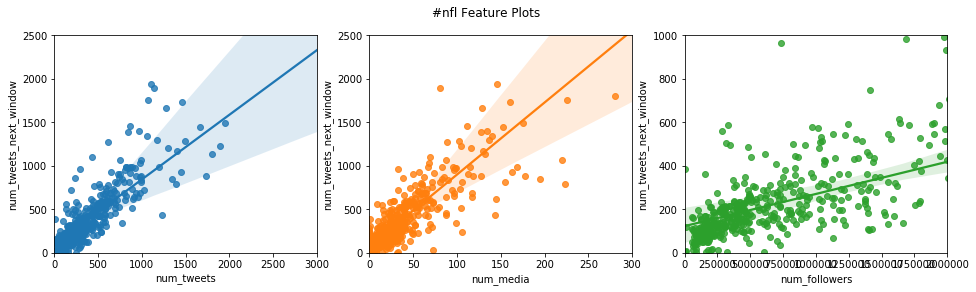

In [11]:
hashtag = 'nfl'
df_hashtag = df_windowed[hashtag]
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("#%s Feature Plots" %hashtag)

g1 = sns.regplot(x='num_tweets', y='num_tweets_next_window', data=df_hashtag, ax=axes[0])
g2 = sns.regplot(x='num_media', y='num_tweets_next_window', data=df_hashtag, ax=axes[1])
g3 = sns.regplot(x='num_followers', y='num_tweets_next_window', data=df_hashtag, ax=axes[2])
g1.set(xlim=(0,3000), ylim=(0,2500))
g2.set(xlim=(0,300), ylim=(0,2500))
_ = g3.set(xlim=(0,2e6), ylim=(0,1000))

[(0, 1000), (0, 6000000.0)]

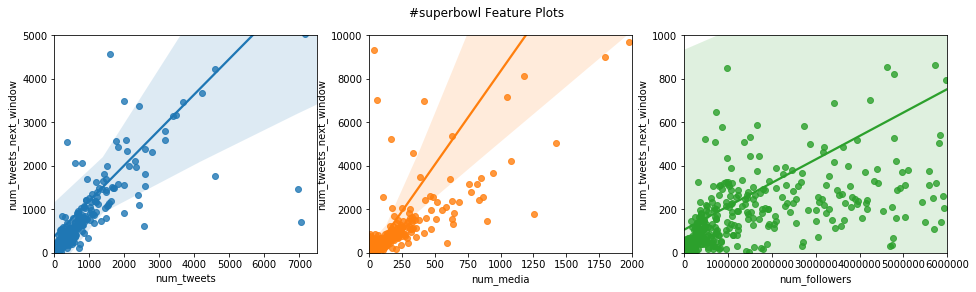

In [12]:
hashtag = 'superbowl'
df_hashtag = df_windowed[hashtag]
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("#%s Feature Plots" %hashtag)

g1 = sns.regplot(x='num_tweets', y='num_tweets_next_window', data=df_hashtag, ax=axes[0])
g2 = sns.regplot(x='num_media', y='num_tweets_next_window', data=df_hashtag, ax=axes[1])
g3 = sns.regplot(x='num_followers', y='num_tweets_next_window', data=df_hashtag, ax=axes[2])
g1.set(xlim=(0,7500), ylim=(0,5000))
g2.set(xlim=(0,2000), ylim=(0,10000))
g3.set(xlim=(0,6e6), ylim=(0,1000))

[(0, 500), (0, 6000000.0)]

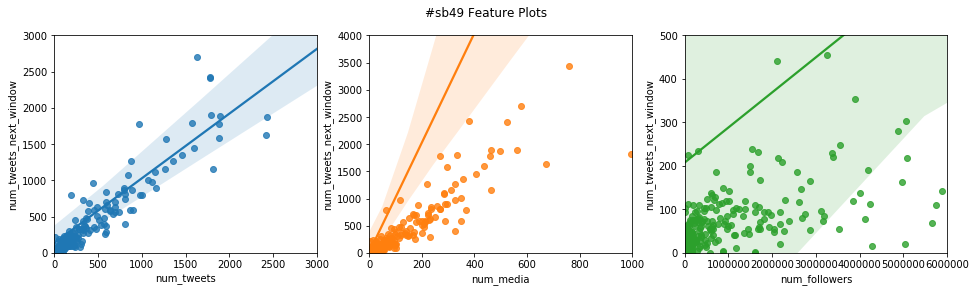

In [13]:
hashtag = 'sb49'
df_hashtag = df_windowed[hashtag]
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("#%s Feature Plots" %hashtag)

g1 = sns.regplot(x='num_tweets', y='num_tweets_next_window', data=df_hashtag, ax=axes[0])
g2 = sns.regplot(x='num_media', y='num_tweets_next_window', data=df_hashtag, ax=axes[1])
g3 = sns.regplot(x='num_followers', y='num_tweets_next_window', data=df_hashtag, ax=axes[2])
g1.set(xlim=(0,3000), ylim=(0,3000))
g2.set(xlim=(0,1000), ylim=(0,4000))
g3.set(xlim=(0,6e6), ylim=(0,500))

[(0, 1000), (0, 2000000.0)]

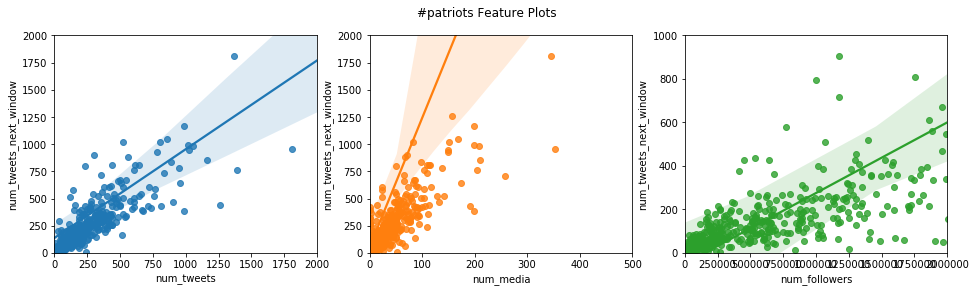

In [14]:
hashtag = 'patriots'
df_hashtag = df_windowed[hashtag]
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("#%s Feature Plots" %hashtag)

g1 = sns.regplot(x='num_tweets', y='num_tweets_next_window', data=df_hashtag, ax=axes[0])
g2 = sns.regplot(x='num_media', y='num_tweets_next_window', data=df_hashtag, ax=axes[1])
g3 = sns.regplot(x='num_followers', y='num_tweets_next_window', data=df_hashtag, ax=axes[2])
g1.set(xlim=(0,2000), ylim=(0,2000))
g2.set(xlim=(0,500), ylim=(0,2000))
g3.set(xlim=(0,2e6), ylim=(0,1000))

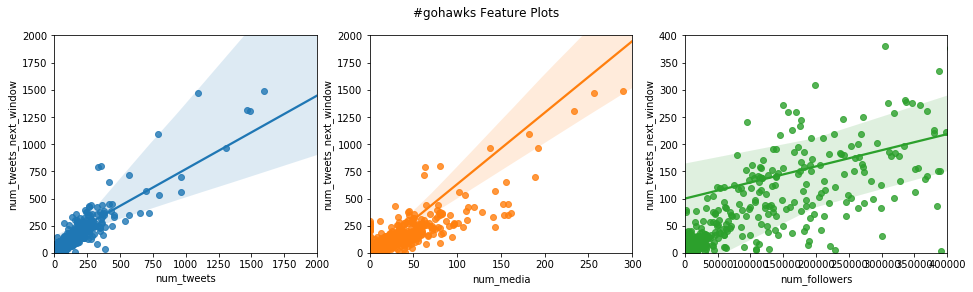

In [15]:
hashtag = 'gohawks'
df_hashtag = df_windowed[hashtag]
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("#%s Feature Plots" %hashtag)

g1 = sns.regplot(x='num_tweets', y='num_tweets_next_window', data=df_hashtag, ax=axes[0])
g2 = sns.regplot(x='num_media', y='num_tweets_next_window', data=df_hashtag, ax=axes[1])
g3 = sns.regplot(x='num_followers', y='num_tweets_next_window', data=df_hashtag, ax=axes[2])
g1.set(xlim=(0,2000), ylim=(0,2000))
g2.set(xlim=(0,300), ylim=(0,2000))
_ = g3.set(xlim=(0,4e5), ylim=(0,400))

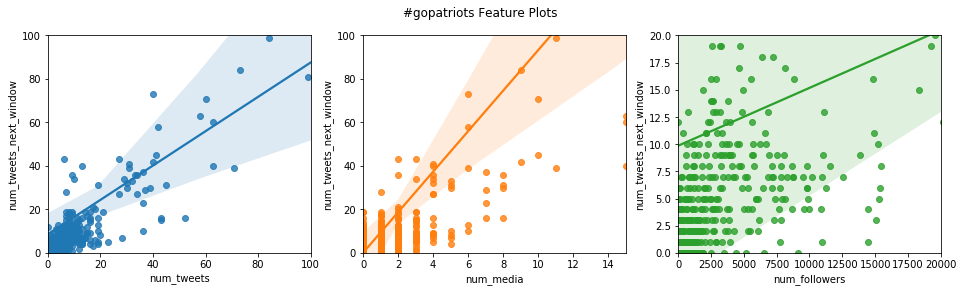

In [16]:
hashtag = 'gopatriots'
df_hashtag = df_windowed[hashtag]
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(16)
fig.set_figheight(4)
fig.suptitle("#%s Feature Plots" %hashtag)

g1 = sns.regplot(x='num_tweets', y='num_tweets_next_window', data=df_hashtag, ax=axes[0])
g2 = sns.regplot(x='num_media', y='num_tweets_next_window', data=df_hashtag, ax=axes[1])
g3 = sns.regplot(x='num_followers', y='num_tweets_next_window', data=df_hashtag, ax=axes[2])
g1.set(xlim=(0,100), ylim=(0,100))
g2.set(xlim=(0,15), ylim=(0,100))
_ = g3.set(xlim=(0,20000), ylim=(0,20))